In [27]:
import pandas as pd
from tqdm import tqdm
import os
import json
import seaborn as sns
import cooler
import bioframe
import cooltools
from os import listdir
from os.path import isfile, join, basename
from io import StringIO
import json
import warnings
import math 
import numpy as np
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore')

In [2]:
from dotenv import load_dotenv
assert os.environ['CONDA_DEFAULT_ENV'] == "cultures_hic"
load_dotenv()

True

# 1. Preprare needed files

In [7]:
def get_hg38_arms():
    hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
    hg38_cens = bioframe.fetch_centromeres('hg38')
    hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)
    return hg38_arms[hg38_arms.chrom!='chrM'].reset_index(drop=True)


def get_source2map(merged_bedpe_clf_2_filtered, maps2loops):
    source2map = {}
    for k in merged_bedpe_clf_2_filtered.source.unique():
        name = k.split("_sampled_dots_final_")[0]
        map = [k for k,i in maps2loops.items() if name in i]
        assert len(map) == 1
        source2map[k] = map[0].split('/')[-1]
    return source2map
    

In [9]:
path_to_maps = os.getenv('PATH_TO_MAPS')
path_to_maps_expected = os.getenv('PATH_TO_EXPECTED_MAPS')
path_to_loops_clusters_data = "./loops_data/loops_clusters_data"

In [6]:
name_appender = ""
save_name = "loops_clustering_post_mortem_vs_iPSC_derived"
path_to_loops_clusters_data = "./loops_data/loops_clusters_data"
merged_all_clusters = pd.read_pickle(f"{path_to_loops_clusters_data}/{save_name}_calculated_clusters_all{name_appender}.pickle")
hg38_arms = get_hg38_arms() 

In [8]:
maps2loops = json.load(open('./loops_data/maps2loops_mapping.json'))
source2map = get_source2map(merged_all_clusters, maps2loops)
sources = merged_all_clusters.source.unique()

In [10]:
maps_stored = {}
for source in sources:
    maps_stored[source] = {}
    map_name = source2map[source]
    print(source, map_name)
    clr = cooler.Cooler(f'{path_to_maps}/{source2map[source]}::/resolutions/{15000}')
    maps_stored[source]['clr'] = clr
    reduced_maps2loops = source2map[source].split('.mcool', 0)[0]
    maps_stored[source]['expected'] = pd.read_pickle(f'{path_to_maps_expected}/{reduced_maps2loops}_perChrArm.pickle')
    

Tian2023_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed Tian2023_NeuNplus.EN_IN.29_42_58_years.2000_cells.sampled_exact.mcool
Zaghi2023_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed Zaghi2023_iPSC_NeuNplus.sampled_exact.mcool
Wu2021_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed Wu2021_iPSC_NeuNplus.sampled_exact.mcool
Rahman2023_iPSC_NeuNplus_CRISPRi_Scrambled_A_DpnII-HinfI_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed Rahman2023_iPSC_NeuNplus_CRISPRi_Scrambled_A_DpnII-HinfI.sampled_exact.mcool
Rajarajan_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed Rajarajan

# 2. Identify params

In [17]:
def get_internal_and_not_internal(merged_all_clusters_source, source):
    """
    Processes the merged clusters source data to separate internal and cluster-based calculations.

    Parameters:
    - merged_all_clusters_source (pd.DataFrame): DataFrame containing cluster source data.
    - source (str): Identifier for the data source.

    Returns:
    Tuple[pd.DataFrame, pd.DataFrame]: A tuple containing DataFrames for internal calculations and cluster calculations.
    """
    merged_all_clusters_source = merged_all_clusters_source[
        ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'calculation', 'cluster', 'source']
    ].sort_values(['chrom1', 'start1', 'end1'])

    cluster_df = merged_all_clusters_source[merged_all_clusters_source['calculation'] == "from_cluster"].copy()
    
    resolution_diff = set(cluster_df['end1'] - cluster_df['start1'])
    if resolution_diff == {45000}:
        adjustment_value = 15000
        cluster_df['start1'] += adjustment_value
        cluster_df['end1'] -= adjustment_value
        cluster_df['start2'] += adjustment_value
        cluster_df['end2'] -= adjustment_value
    elif resolution_diff == {15000}:
        print('All resolutions set to 15kb')
    else:
        raise ValueError('Not valid resolution')

    internal_df = merged_all_clusters_source[merged_all_clusters_source['calculation'] != "from_cluster"]
    
    return internal_df, cluster_df

def create_matrix_calculated(source, merged_all_clusters_cluster):
    """
    Creates a matrix from the calculated pileup stack for a given source and cluster data.

    Parameters:
    - source (str): Identifier for the data source.
    - merged_all_clusters_cluster (pd.DataFrame): DataFrame containing cluster data.

    Returns:
    Tuple[np.ndarray, np.ndarray]: A tuple containing the stack and the mean matrix.
    """
    flank_size = 3 * 15_000  
    stack = cooltools.pileup(
        maps_stored[source]['clr'],
        merged_all_clusters_cluster,
        view_df=hg38_arms,
        expected_df=maps_stored[source]['expected'],
        flank=flank_size
    )
    
    mean_matrix = np.nanmean(stack, axis=0)
    return stack, mean_matrix

In [18]:
def create_matrix_calculated_test_large_flank(source, merged_all_clusters_cluster, flank=10*15_000):    
    stack = cooltools.pileup(maps_stored[source]['clr'], 
                             merged_all_clusters_cluster, 
                             view_df=hg38_arms, 
                             expected_df=maps_stored[source]['expected'], 
                             flank=flank)
    
    mtx = np.nanmean(stack, axis=0)
    return mtx, stack

def plot_loop(mtx_from_cluster, resolution = 15_000):    
    flank=3*resolution
    plt.imshow(
        np.log2(mtx_from_cluster),
        cmap='coolwarm')
    
    plt.colorbar(label = 'log2 mean obs/exp')
    ticks_pixels = np.linspace(0, flank*2//resolution,5)
    ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
    plt.xticks(ticks_pixels, ticks_kbp)
    plt.yticks(ticks_pixels, ticks_kbp)
    plt.xlabel('relative position, kbp')
    plt.ylabel('relative position, kbp')    
    plt.show()

def get_ratio_3to3(stack_from_internal):
    loops_ratios_internal = []
    mean_central_all = []
    for loop in stack_from_internal:
        central_3x3 = loop[2:5, 2:5]
        mean_central = np.mean(central_3x3)
        arr_copy = loop.copy()
        arr_copy[2:5, 2:5] = np.nan
        mean_others = np.nanmean(arr_copy)
        loops_ratios_internal.append(mean_central / mean_others)
        mean_central_all.append(mean_central)
    return loops_ratios_internal, mean_central_all

In [19]:
source = merged_all_clusters.source.unique()[0]
print(source)
merged_all_clusters_source = merged_all_clusters[merged_all_clusters.source == source]
merged_all_clusters_internal, merged_all_clusters_cluster = get_internal_and_not_internal(merged_all_clusters_source, source)

Tian2023_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
All resolutions set to 15kb


In [22]:
test_mtx_from_cluster, test_stack_cluster = create_matrix_calculated_test_large_flank(source, merged_all_clusters_cluster)
test_mtx_from_internal, test_stack_internal = create_matrix_calculated_test_large_flank(source, merged_all_clusters_internal)

In [23]:
new_df = merged_all_clusters_internal.copy()
for chrom in new_df['chrom1'].unique().copy():
    max_end1 = new_df[new_df['chrom1'] == chrom]['end1'].max()
    max_end2 = new_df[new_df['chrom1'] == chrom]['end2'].max()
    max_end = min(max_end1, max_end2)
    
    chrom_df = new_df[new_df['chrom1'] == chrom]
    chrom_df['start1'] = np.random.randint(0, max_end - 15000, size=len(chrom_df)).copy()
    chrom_df['start2'] = chrom_df['start1'] + np.random.randint(0, chrom_df['start2'].max() - chrom_df['start1'], size=len(chrom_df)).copy()
    
    chrom_df['end1'] = chrom_df['start1'] + 15000
    chrom_df['end2'] = chrom_df['start2'] + 15000

    chrom_df['end1'] = chrom_df['end1'].where(chrom_df['end1'] <= max_end1, max_end1).copy()
    chrom_df['end2'] = chrom_df['end2'].where(chrom_df['end2'] <= max_end2, max_end2).copy()
    
    new_df.update(chrom_df)
new_df.start1 = new_df.start1.astype(int)
new_df.end1 = new_df.end1.astype(int)
new_df.start2 = new_df.start2.astype(int)
new_df.end2 = new_df.end2.astype(int)

In [25]:
stack_from_internal_permutated, mtx_from_internal_permutated = create_matrix_calculated(source, new_df)
stack_from_cluster, mtx_from_cluster = create_matrix_calculated(source, merged_all_clusters_cluster)
stack_from_internal, mtx_from_internal = create_matrix_calculated(source, merged_all_clusters_internal)


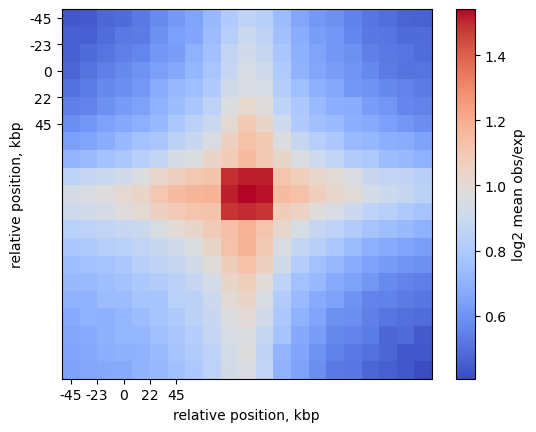

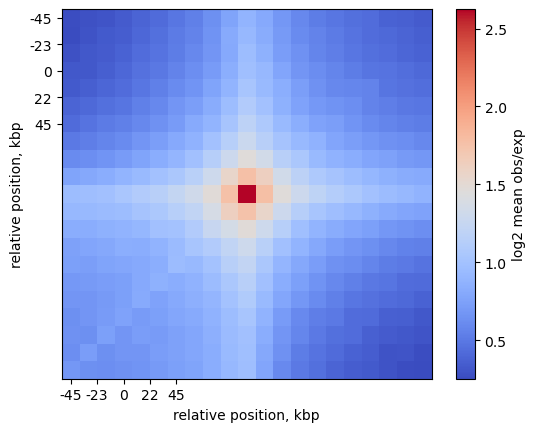

In [28]:
plot_loop(test_mtx_from_cluster)
plot_loop(test_mtx_from_internal)

In [29]:
loops_ratios_internal,mean_central_all =  get_ratio_3to3(stack_from_internal)
loops_ratios_internal = [v for v in loops_ratios_internal if not math.isnan(v) and not math.isinf(v)]

loops_ratios_cluster,mean_central_all =  get_ratio_3to3(stack_from_cluster)
loops_ratios_cluster = [i for i in loops_ratios_cluster if not np.isnan(i)]

loops_ratios_internal_perm, mean_central_all_perm =  get_ratio_3to3(stack_from_internal_permutated)
loops_ratios_internal_perm = [v for v in loops_ratios_internal_perm if not math.isnan(v) and not math.isinf(v)]


# 3. Implement calculation

In [32]:
def process_clusters(merged_all_clusters, save_name):
    """
    Processes clusters from the merged data, calculates loop ratios,
    and saves the results to a pickle file.

    Args:
        merged_all_clusters (pd.DataFrame): DataFrame containing the cluster data.
        save_name (str): Base name for the output file.
    """
    merged_all_clusters_concat_all = pd.DataFrame()
    lower_values, lower_values_central = [], []

    for source in tqdm(merged_all_clusters['source'].unique(), desc="Processing Sources"):
        print(f"Processing source: {source}")
        
        merged_all_clusters_source = merged_all_clusters[merged_all_clusters['source'] == source]

        # Get internal and non-internal clusters
        merged_all_clusters_internal, merged_all_clusters_cluster = get_internal_and_not_internal(merged_all_clusters_source, source)

        stack_from_cluster, mtx_from_cluster = create_matrix_calculated(source, merged_all_clusters_cluster)
        stack_from_internal, mtx_from_internal = create_matrix_calculated(source, merged_all_clusters_internal)

        # Calculate loop ratios and means
        loops_ratios_internal, mean_central_internal = get_ratio_3to3(stack_from_internal)
        loops_ratios_cluster, mean_central_cluster = get_ratio_3to3(stack_from_cluster)

        assert merged_all_clusters_internal['cluster'].nunique() == len(loops_ratios_internal) == len(stack_from_internal)
        assert merged_all_clusters_cluster['cluster'].nunique() == len(loops_ratios_cluster) == len(stack_from_cluster)

        # Calculate lower quantile values
        loops_ratios_internal_for_calculation = [v for v in loops_ratios_internal if not math.isnan(v) and not math.isinf(v)]
        lower_value = np.quantile(loops_ratios_internal_for_calculation, 0.1)
        lower_values.append(lower_value)

        mean_central_cluster_for_calculation = [v for v in mean_central_cluster if not math.isnan(v) and not math.isinf(v)]
        lower_value_central = np.quantile(mean_central_cluster_for_calculation, 0.1)
        lower_values_central.append(lower_value_central)

        merged_all_clusters_internal['loop_ratio'] = loops_ratios_internal
        merged_all_clusters_cluster['loop_ratio'] = loops_ratios_cluster
        merged_all_clusters_internal['mean_central'] = mean_central_internal
        merged_all_clusters_cluster['mean_central'] = mean_central_cluster

        # Concatenate internal and cluster data
        merged_all_clusters_concat = pd.concat([merged_all_clusters_internal, merged_all_clusters_cluster])
        
        assert merged_all_clusters_concat['cluster'].nunique() == merged_all_clusters_source['cluster'].nunique()
        assert merged_all_clusters_concat.shape[0] == merged_all_clusters_source.shape[0]

        merged_all_clusters_concat['is_loop_loop_ratio'] = merged_all_clusters_concat['loop_ratio'].apply(
            lambda x: not pd.isna(x) and x > lower_value
        )
        merged_all_clusters_concat['is_loop_loop_central'] = merged_all_clusters_concat['mean_central'].apply(
            lambda x: not pd.isna(x) and x > lower_value_central
        )

        merged_all_clusters_concat_all = pd.concat([merged_all_clusters_concat_all, merged_all_clusters_concat], ignore_index=True)

    assert merged_all_clusters.shape[0] == merged_all_clusters_concat_all.shape[0]
    output_path = f"{path_to_loops_clusters_data}/{save_name}_calculated_clusters_all_withLoopNotation_withCentral.pickle"
    merged_all_clusters_concat_all.to_pickle(output_path)
    print(f"Data saved to {output_path}")

In [33]:
save_name = 'loops_clustering_post_mortem_vs_iPSC_derived'
process_clusters(merged_all_clusters, save_name)

Processing Sources:   0%|                                                                                                                         | 0/12 [00:00<?, ?it/s]

Processing source: Tian2023_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
All resolutions set to 15kb


Processing Sources:   8%|█████████▍                                                                                                       | 1/12 [01:26<15:56, 86.93s/it]

Processing source: Zaghi2023_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
All resolutions set to 15kb


Processing Sources:  17%|██████████████████▊                                                                                              | 2/12 [02:40<13:08, 78.81s/it]

Processing source: Wu2021_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
All resolutions set to 15kb


Processing Sources:  25%|████████████████████████████▎                                                                                    | 3/12 [04:12<12:46, 85.20s/it]

Processing source: Rahman2023_iPSC_NeuNplus_CRISPRi_Scrambled_A_DpnII-HinfI_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
All resolutions set to 15kb


Processing Sources:  33%|█████████████████████████████████████▋                                                                           | 4/12 [05:41<11:31, 86.45s/it]

Processing source: Rajarajan_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
All resolutions set to 15kb


Processing Sources:  42%|███████████████████████████████████████████████                                                                  | 5/12 [07:12<10:16, 88.06s/it]

Processing source: Pletenev2024_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
All resolutions set to 15kb


Processing Sources:  50%|████████████████████████████████████████████████████████▌                                                        | 6/12 [08:43<08:54, 89.15s/it]

Processing source: Heffel_adult_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
All resolutions set to 15kb


Processing Sources:  58%|█████████████████████████████████████████████████████████████████▉                                               | 7/12 [10:00<07:06, 85.23s/it]

Processing source: Rahman2023_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
All resolutions set to 15kb


Processing Sources:  67%|███████████████████████████████████████████████████████████████████████████▎                                     | 8/12 [11:33<05:50, 87.57s/it]

Processing source: Our_data_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
All resolutions set to 15kb


Processing Sources:  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 9/12 [12:53<04:15, 85.30s/it]

Processing source: Ballerino2022_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
All resolutions set to 15kb


Processing Sources:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                  | 10/12 [14:08<02:44, 82.05s/it]

Processing source: Li2022_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
All resolutions set to 15kb


Processing Sources:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 11/12 [15:38<01:24, 84.57s/it]

Processing source: Hu2021_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
All resolutions set to 15kb


Processing Sources: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [17:02<00:00, 85.18s/it]

Data saved to ./loops_data/loops_clusters_data/loops_clustering_post_mortem_vs_iPSC_derived_calculated_clusters_all_withLoopNotation_withCentral.pickle
